In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer,StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import xgboost as xgb

from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Masking
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from keras.callbacks import ModelCheckpoint  

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# downloading the kaggle data
!kaggle competitions download -c the-winton-stock-market-challenge
!unzip train.csv.zip
!unzip test_2.csv.zip
!unzip sample_submission_2.csv.zip

 80% 58.0M/72.7M [00:00<00:00, 44.7MB/s]
100% 72.7M/72.7M [00:00<00:00, 78.8MB/s]
100% 16.1M/16.1M [00:01<00:00, 17.5MB/s]

 95% 109M/114M [00:00<00:00, 106MB/s]  
100% 114M/114M [00:01<00:00, 116MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  test_2.csv.zip
  inflating: test_2.csv              
  inflating: __MACOSX/._test_2.csv   
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
  inflating: __MACOSX/._sample_submission_2.csv  


As the below Xgboost taked 16 hours to complete all the 6 rows i have ran the below cell by changing the indexes

In [0]:
%%time

# downloading the kaggle data
!kaggle competitions download -c the-winton-stock-market-challenge
!unzip train.csv.zip
!unzip test_2.csv.zip
!unzip sample_submission_2.csv.zip

training_csv = pd.read_csv('train.csv', index_col=0)
testing_csv = pd.read_csv('test_2.csv', index_col=0)

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# msk = np.random.rand(len(df)) < 0.8
# print(msk)
# training_csv = df[msk]
# testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_csv.values

# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
for Number in pro(range(45,63)): # From 1 to 62

    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
    elif Number == 62:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_'+str(Number+120)
        name_of_weight = 'Weight_Intraday'


    train_targets = training_csv[name_of_column].values
    train_weights = training_csv[name_of_weight].values
    training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
    training_data = training_data.values
    testing_data = testing_csv.values

    data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
    data_test = xgb.DMatrix(testing_data, missing=np.NaN)

    model_parameters = {'max_depth': 10, 'eta': 0.1, 'silent': 1, 'gamma': 0, 'lambda': 500, 'alpha': 400}
    number_of_rounds = 500

    watchlist = [(data_train, 'train')]
    bst = xgb.train(model_parameters, data_train, number_of_rounds, watchlist, early_stopping_rounds=10,verbose_eval=0)

    predictions = bst.predict(data_test)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P})

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
output.to_csv(path_or_buf="output30.csv",index=False)
print(output.head())

 83% 60.0M/72.7M [00:00<00:00, 75.9MB/s]
100% 72.7M/72.7M [00:00<00:00, 148MB/s] 
 37% 6.00M/16.1M [00:00<00:00, 62.8MB/s]
100% 16.1M/16.1M [00:00<00:00, 103MB/s] 
 94% 108M/114M [00:01<00:00, 90.3MB/s] 
100% 114M/114M [00:01<00:00, 88.2MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  test_2.csv.zip
  inflating: test_2.csv              
  inflating: __MACOSX/._test_2.csv   
Archive:  sample_submission_2.csv.zip
  inflating: sample_submission_2.csv  
  inflating: __MACOSX/._sample_submission_2.csv  


100% (18 of 18) |########################| Elapsed Time: 5:10:26 Time:  5:10:26


               Id  Predicted
99999   100000_45   0.000114
219999  100000_46  -0.000053
339999  100000_47  -0.000194
459999  100000_48  -0.000068
579999  100000_49   0.000265
CPU times: user 10h 18min 52s, sys: 10.7 s, total: 10h 19min 3s
Wall time: 5h 11min 3s


In [1]:
import shutil
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path='drive/My Drive/AAIC/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


In [0]:
path='drive/My Drive/AAIC'
output.to_csv(path_or_buf="output60.csv",index=True)
shutil.copy('output60.csv',path)

'drive/My Drive/AAIC/output60.csv'

In [0]:
# 1 
path='drive/My Drive/AAIC'
df1=pd.read_csv(path+"/output15.csv",index_col='Unnamed: 0')
df2=pd.read_csv(path+"/output30.csv",index_col='Unnamed: 0')
df3=pd.read_csv(path+"/output45.csv")
df4=pd.read_csv(path+"/output60.csv",index_col='Unnamed: 0')
# df1.head()

In [0]:
dict1 = dict(zip(df1.Id, df1.Predicted))
dict2 = dict(zip(df2.Id, df2.Predicted))
dict3 = dict(zip(df3.Id, df3.Predicted))
dict4 = dict(zip(df4.Id, df4.Predicted))

In [0]:
len(dict4.items())

7440000

In [0]:
dict2.update(dict1)
dict3.update(dict2)
dict4.update(dict3)

In [0]:
files_path=''
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)

first = ['Id']
allcol = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130',
'Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141',
'Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152',
'Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163',
'Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174',
'Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180','Ret_PlusOne','Ret_PlusTwo']

total = first + allcol
feature_cols = [col for col in df.columns if col not in total] 

intraDay_cols = ['Ret_PlusOne','Ret_PlusTwo']
X = df[feature_cols] # .loc[:, 'Feature_1':'Ret_120'] 
y = df[intraDay_cols] #.loc[:, 'Ret_121':'Weight_Daily'] 


dailyReturn_cols = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130',
'Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141',
'Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152',
'Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163',
'Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174',
'Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
X_train_raw = X
y_train_raw = y

In [0]:
df_test = pd.read_csv(files_path+'test_2.csv')
df_test.fillna(df_test.mean(axis=0), inplace=True)
feature_cols = [col for col in df_test.columns if col not in total] 
X_test_intraday = df_test[feature_cols] # .loc[:, 'Feature_1':'Ret_120'] 
# y_test_intraday = df_test[allcol] #.loc[:, 'Ret_121':'Weight_Daily'] 

In [0]:
def preprocess_data(x_raw, y_raw):
    # top 25 features
    features = x_raw.loc[:, 'Feature_1':'Feature_25'].values[:, None, :]

    # 120 return values
    returns_intraday = x_raw.loc[:, 'Ret_2':'Ret_120'].values[:, :, None]
    print("No of repeatitions : ",returns_intraday.shape[1])
    
    features_repeated = np.repeat(features, returns_intraday.shape[1], axis=1)
    X_intraday = np.dstack((features_repeated, returns_intraday))
    
    returns_daily = x_raw.loc[:, 'Ret_MinusTwo':'Ret_MinusOne'].values[:, :, None]
    print("No of repeatitions : ",returns_daily.shape[1])
    features_repeated = np.repeat(features, returns_daily.shape[1], axis=1)
    X_daily = np.dstack((features_repeated, returns_daily))
    
    # targets should consist of returns only
    y_intraday = y_raw.loc[:, 'Ret_121':'Ret_180']
    y_daily = y_raw.loc[:, 'Ret_PlusOne':'Ret_PlusTwo']
    
    return X_intraday, X_daily, y_intraday, y_daily
  
X_train_intraday, X_train_daily, y_train_intraday, y_train_daily = preprocess_data(X_train_raw, y_train_raw)    
X_test_intraday, X_test_daily, y_test_intraday, y_test_daily= preprocess_data(X_test_raw, y_test_raw)  

No of repeatitions :  119
No of repeatitions :  2
No of repeatitions :  119
No of repeatitions :  2


In [0]:
# should be ignored y_test_intraday 
X_test_intraday.shape

(8000, 119, 26)

In [0]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='relu',
                     dropout=.4, loss='mae', loss_weights=None, sample_weight_mode=None,
                     optimizer='adam'):
    model = Sequential()
    # https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs
    # https://www.quora.com/What-is-masking-in-a-recurrent-neural-network-RNN
    model.add(Masking(mask_value=0., input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    model.add(Dropout(dropout))
    model.add(Dense(units=2 * neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, loss_weights=loss_weights, sample_weight_mode=sample_weight_mode, optimizer=optimizer)
    print(model.summary())
    return model
  
lstm_neurons = 250
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20
optimizer = 'adam'
activ_func = 'relu'

checkpointer_intraday = ModelCheckpoint(filepath='best_weights_intraday.hdf5', 
                               verbose=1, save_best_only=True)
model_intraday = build_lstm_model(X_train_intraday, y_train_intraday.shape[1], neurons=lstm_neurons, 
                               activ_func=activ_func, optimizer=optimizer,
                               dropout=dropout)
history_intraday = model_intraday.fit(X_train_intraday, y_train_intraday, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                          epochs=epochs, callbacks=[checkpointer_intraday])  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 119, 26)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               277000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               125500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 60)                30060     
_________________________________________________________________
activation_2 (Activation)    (None, 60)               

In [0]:
model_daily.predict(X_test_daily)

In [0]:
dict4['60_1']
dict4['61_1']
dict4['62_1']

2.7626752853393555e-05

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k, 'Predicted': dict4[k]})

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m "Message"

In [0]:
%%time

from sklearn.linear_model import LinearRegression
training_csv = pd.read_csv('train.csv', index_col=0)
testing_csv = pd.read_csv('test_2.csv', index_col=0)

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# msk = np.random.rand(len(df)) < 0.8
# print(msk)
# training_csv = df[msk]
# testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_csv.values

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
training_data = training_data.values
# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
t1=[]
t2=[]
for Number in pro(range(0,63)): # From 1 to 62

    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
    elif Number == 62:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_'+str(Number+120)
        name_of_weight = 'Weight_Intraday'


    train_targets = training_csv[name_of_column].values
    train_weights = training_csv[name_of_weight].values
    testing_data = testing_csv.values

#     data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
#     data_test = xgb.DMatrix(testing_data, missing=np.NaN)
    model = LinearRegression()
    training_data = np.nan_to_num(training_data,0)
    testing_data = np.nan_to_num(testing_data,0)
    train_targets = np.nan_to_num(train_targets,0)
    
    
    model.fit(training_data,train_targets)
#     y_train = y_train.astype('float32')
#     y_train = y_train.fillna(0)

#     y_test = y_test.astype('float32')
#     y_test = y_test.fillna(0)
    t1.append(train_targets)
    t2.append(model.predict(training_data))
    predictions = model.predict(testing_data)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P})

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
output.to_csv(path_or_buf="output30.csv",index=False)
print(output.head())

100% (63 of 63) |########################| Elapsed Time: 0:01:08 Time:  0:01:08


                Id  Predicted
99999     100000_0   0.000787
219999    100000_1   0.000099
1299999  100000_10   0.000225
1419999  100000_11  -0.000052
1539999  100000_12   0.000007
CPU times: user 2min 16s, sys: 14.7 s, total: 2min 30s
Wall time: 1min 52s


In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(t1,t2)

1.8656180118558996e-05

In [0]:
%%time

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
training_csv = pd.read_csv('train.csv', index_col=0)
testing_csv = pd.read_csv('test_2.csv', index_col=0)

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# msk = np.random.rand(len(df)) < 0.8
# print(msk)
# training_csv = df[msk]
# testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_csv.values

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
training_data = training_data.values
# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
t1=[]
t2=[]
for Number in pro(range(0,63)): # From 1 to 62

    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
    elif Number == 62:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_'+str(Number+120)
        name_of_weight = 'Weight_Intraday'


    train_targets = training_csv[name_of_column].values
    train_weights = training_csv[name_of_weight].values
    testing_data = testing_csv.values

#     data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
#     data_test = xgb.DMatrix(testing_data, missing=np.NaN)
    model = SVR(kernel='linear', C=1e3)
    training_data = np.nan_to_num(training_data,0)
    testing_data = np.nan_to_num(testing_data,0)
    train_targets = np.nan_to_num(train_targets,0)
    
    
    model.fit(training_data,train_targets)
#     y_train = y_train.astype('float32')
#     y_train = y_train.fillna(0)

#     y_test = y_test.astype('float32')
#     y_test = y_test.fillna(0)
    t1.append(train_targets)
    t2.append(model.predict(training_data))
    predictions = model.predict(testing_data)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P})

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
output.to_csv(path_or_buf="output30.csv",index=False)
print(output.head())
mean_squared_error(t1,t2) 

 96% (61 of 63) |####################### | Elapsed Time: 0:00:41 ETA:   0:00:01

In [0]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
training_csv = pd.read_csv('train.csv', index_col=0)
testing_csv = pd.read_csv('test_2.csv', index_col=0)

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# msk = np.random.rand(len(df)) < 0.8
# print(msk)
# training_csv = df[msk]
# testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_csv.values

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
training_data = training_data.values
# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
t1=[]
t2=[]
for Number in pro(range(0,63)): # From 1 to 62

    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
        break
    elif Number == 62:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_'+str(Number+120)
        name_of_weight = 'Weight_Intraday'


    train_targets = training_csv[name_of_column].values
    train_weights = training_csv[name_of_weight].values
    testing_data = testing_csv.values

#     data_train = xgb.DMatrix(training_data, label=train_targets, missing=np.NaN, weight=train_weights)
#     data_test = xgb.DMatrix(testing_data, missing=np.NaN)
    model = SVR(kernel='linear', C=1e3)
    training_data = np.nan_to_num(training_data,0)
    testing_data = np.nan_to_num(testing_data,0)
    train_targets = np.nan_to_num(train_targets,0)
    
    
    model.fit(training_data,train_targets)
#     y_train = y_train.astype('float32')
#     y_train = y_train.fillna(0)

#     y_test = y_test.astype('float32')
#     y_test = y_test.fillna(0)
    t1.append(train_targets)
    t2.append(model.predict(training_data))
    predictions = model.predict(testing_data)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P})

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
output.to_csv(path_or_buf="output30.csv",index=False)
print(output.head())

 96% (61 of 63) |####################### | Elapsed Time: 0:00:36 ETA:   0:00:01

                Id  Predicted
99999     100000_0   0.043818
219999    100000_1   0.014709
1299999  100000_10  -0.003318
1419999  100000_11  -0.001375
1539999  100000_12   0.008735
CPU times: user 1min 19s, sys: 780 ms, total: 1min 20s
Wall time: 1min 20s


In [0]:
mean_squared_error(t1,t2) 

0.00019977672152186372

In [0]:
mean_squared_error(t1,t2) 

0.00019977672152186372

In [0]:
dict1 = dict(zip(output.Id, output.Predicted))

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': (dict1[k]+dict4[k] )/2
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m "XGBoost + Linear regression"

100% 226M/226M [00:07<00:00, 32.0MB/s]
Successfully submitted to The Winton Stock Market Challenge

In [0]:
dict1['1_1']

0.00019045966732976504

In [0]:
dict4['1_1']

0.0004201829433441162

In [0]:
dict1['61_1']

-0.00010033381161201894

In [0]:
dict4['61_1']

-8.529424667358398e-05

In [0]:
(dict4['1_1']+dict1['1_1'])/2

0.0003053213053369406

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': (dict1[k] )
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="linear_regression.csv",index=False)

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': dict4[k]
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="Xgboost-data.csv",index=False)
# !kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m "with bias .5"

In [0]:
path='drive/My Drive/AAIC'

shutil.copy('linear_regression.csv',path)
shutil.copy('Xgboost-data.csv',path)

'drive/My Drive/AAIC/Xgboost-data.csv'

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': dict4[k]
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="Xgboost-data.csv",index=False)
# !kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m "with bias .5"

In [0]:
np.zeros(40000)+0.5

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [0]:
mean_squared_error(train_targets,np.zeros(40000))

0.0005837107094561095

In [0]:
mean_squared_error(train_targets,np.zeros(40000)+10e-6)

0.0005837105721499144

In [6]:
path='drive/My Drive/AAIC'

shutil.copy(path+'/randomForest.csv','.')
shutil.copy(path+'/ExtraTreesRegressor.csv','.')
# ExtraTreesRegressor
# shutil.copy('Xgboost-data.csv',path)

'./ExtraTreesRegressor.csv'

In [0]:
df1=pd.read_csv('ExtraTreesRegressor.csv')
df2=pd.read_csv('randomForest.csv')
df3=pd.read_csv('linear_regression.csv')
df4=pd.read_csv('Xgboost-data.csv')
dict_1 = dict(zip(df1.Id, df1.Predicted))
dict_2 = dict(zip(df2.Id, df2.Predicted))
dict_3 = dict(zip(df3.Id, df3.Predicted))
dict_4 = dict(zip(df4.Id, df4.Predicted))

In [0]:
print(dict_1['1_1'])
print(dict_2['1_1'])
print(dict_3['1_1'])
print(dict_4['1_1'])

0.00033327448678133263
-8.699173362735828e-06
0.00019045966732976504
0.0004201829433441162


In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': (dict_2[k])/2
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m "  randomForest/2"

100% 226M/226M [00:06<00:00, 38.3MB/s]
Successfully submitted to The Winton Stock Market Challenge

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': 10e-6
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m " 10e-6"

usage: kaggle competitions submit [-h] -f FILE_NAME -m MESSAGE [-q]
                                  [competition]
kaggle competitions submit: error: argument -m/--message: expected one argument


In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': -10e-6
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m " -10e-6"

100% 113M/113M [00:02<00:00, 43.5MB/s]
Successfully submitted to The Winton Stock Market Challenge

In [0]:
df1.shape

(7440000, 2)

In [0]:
major_list=[]

In [0]:
# Importing gc module 
import gc 
  
# Returns the number of 
# objects it has collected 
# and deallocated 
collected = gc.collect() 
  
# Prints Garbage collector  
# as 0 object 
print("Garbage collector: collected", 
          "%d objects." % collected) 

Garbage collector: collected 2692 objects.


In [0]:
dict_1={}
dict_2={}
dict_3={}
dict_4={}

In [0]:
%%time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
training_csv = pd.read_csv('train.csv', index_col=0)
testing_csv = pd.read_csv('test_2.csv', index_col=0)

model_parameters = {'max_depth': 10, 
                    'eta': 0.1,
                    'silent': 1, 
                    'gamma': 0, 
                    'lambda': 500,
                    'alpha': 400,
                    'verbose':0}
number_of_rounds = 500
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
# msk = np.random.rand(len(df)) < 0.8
# print(msk)
# training_csv = df[msk]
# testing_csv = df[~msk]
res =  pd.DataFrame()

mse_list=[]
major_list=[]
pro =ProgressBar()

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
# testing_data = testing_csv.drop(testing_csv.columns[range(146, 210)], axis=1)

training_data = training_data.values
testing_data = testing_csv.values

training_data = training_csv.drop(training_csv.columns[range(146, 210)], axis=1)
training_data = training_data.values
# as we plot only Ret_1 for every model to compare test prediction and actual value
plot_res =  pd.DataFrame()
t1=[]
t2=[]
for Number in pro(range(61,63)): # From 1 to 62

    if Number == 61:
        name_of_column = 'Ret_PlusOne'
        name_of_weight = 'Weight_Daily'
    elif Number == 62:
        name_of_column = 'Ret_PlusTwo'
        name_of_weight = 'Weight_Daily'
    else:
        name_of_column = 'Ret_'+str(Number+120)
        name_of_weight = 'Weight_Intraday'


    train_targets = training_csv[name_of_column].values
    train_weights = training_csv[name_of_weight].values
    testing_data = testing_csv.values

    model = Sequential()
    model.add(Dense(256, input_dim=146, kernel_initializer='normal'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam', metrics=['mse','mae'])
    
    training_data = np.nan_to_num(training_data,0)
    testing_data = np.nan_to_num(testing_data,0)
    train_targets = np.nan_to_num(train_targets,0)
    
    
    model.fit(training_data,train_targets,epochs=10, batch_size=50,verbose=0)
    
    t1.append(train_targets)
    t2.append(model.predict(training_data))
    predictions = model.predict(testing_data)
    for ID, P in enumerate(predictions):
        major_list.append({'Id': str(ID+1)+'_'+str(Number), 'Predicted': P})

output = pd.DataFrame(data=major_list)
output.sort_values(by='Id', inplace=True)
output.to_csv(path_or_buf="DeepLearning.csv",index=False)
print(output.head())

100% (2 of 2) |##########################| Elapsed Time: 0:02:09 Time:  0:02:09


               Id       Predicted
99999   100000_61    [0.00459889]
219999  100000_62  [0.0030135247]
100000  100001_61  [0.0045988895]
220000  100001_62  [0.0030135245]
100001  100002_61  [0.0045988895]
CPU times: user 3min 1s, sys: 2.32 s, total: 3min 3s
Wall time: 2min 35s


In [0]:
dict_2 = dict(zip(output.Id, output.Predicted))

In [0]:
dict_1 = dict(zip(output.Id, output.Predicted))

In [0]:
dict_1.update(dict_2)

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    try:
      dict_1[k]=dict_1[k][0]
    except:
      5

In [0]:
dict_1['1_1']

-0.0008346188

In [0]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': dict_1[k]
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m " deeplearning 4 layers"

100% 225M/225M [00:03<00:00, 61.7MB/s]
Successfully submitted to The Winton Stock Market Challenge

In [0]:
embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2500, embed_dim,input_length = 146, dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [41]:
def preprocess_data(x_raw, y_raw):
    # top 25 features
    features = x_raw.loc[:, 'Feature_1':'Feature_25'].values[:, None, :]

    # 120 return values
    returns_intraday = x_raw.loc[:, 'Ret_2':'Ret_120'].values[:, :, None]
    print("No of repeatitions : ",returns_intraday.shape[1])
    
    features_repeated = np.repeat(features, returns_intraday.shape[1], axis=1)
    X_intraday = np.dstack((features_repeated, returns_intraday))
    
    returns_daily = x_raw.loc[:, 'Ret_MinusTwo':'Ret_MinusOne'].values[:, :, None]
    print("No of repeatitions : ",returns_daily.shape[1])
    features_repeated = np.repeat(features, returns_daily.shape[1], axis=1)
    X_daily = np.dstack((features_repeated, returns_daily))
    
    # targets should consist of returns only
    y_intraday = y_raw.loc[:, 'Ret_121':'Ret_180']
    y_daily = y_raw.loc[:, 'Ret_PlusOne':'Ret_PlusTwo']
    
    return X_intraday, X_daily, y_intraday, y_daily
files_path=''  
df = pd.read_csv(files_path+'train.csv')
df.fillna(df.mean(axis=0), inplace=True)  
first = ['Id']
allcol = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130',
'Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141',
'Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152',
'Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163',
'Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174',
'Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180','Ret_PlusOne','Ret_PlusTwo']

total = first + allcol
feature_cols = [col for col in df.columns if col not in total] 

X = df[feature_cols] # .loc[:, 'Feature_1':'Ret_120'] 
y = df[allcol] #.loc[:, 'Ret_121':'Weight_Daily'] 

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_intraday, X_train_daily, y_train_intraday, y_train_daily = preprocess_data(X_train_raw, y_train_raw)    
X_test_intraday, X_test_daily, y_test_intraday, y_test_daily= preprocess_data(X_test_raw, y_test_raw)  

No of repeatitions :  119
No of repeatitions :  2
No of repeatitions :  119
No of repeatitions :  2


In [42]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='relu',
                     dropout=.4, loss='mae', loss_weights=None, sample_weight_mode=None,
                     optimizer='adam'):
    model = Sequential()
    # https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs
    # https://www.quora.com/What-is-masking-in-a-recurrent-neural-network-RNN
    model.add(Masking(mask_value=0., input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))) 
    model.add(Dropout(dropout))
    model.add(Dense(units=2 * neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, loss_weights=loss_weights, sample_weight_mode=sample_weight_mode, optimizer=optimizer)
    print(model.summary())
    return model
  
lstm_neurons = 100
epochs = 3
batch_size = 500
loss = 'mae'
dropout = 0.20

checkpointer_daily = ModelCheckpoint(filepath='best_weights_daily.hdf5', 
                               verbose=1, save_best_only=True)
model_daily = build_lstm_model(X_train_daily, y_train_daily.shape[1], neurons=lstm_neurons, 
                               activ_func='relu', optimizer='adam',
                               dropout=0.3)
history_daily = model_daily.fit(X_train_daily, y_train_daily, validation_split=0.25, batch_size=batch_size, 
                           verbose=1, shuffle=True,
                          epochs=epochs, callbacks=[checkpointer_daily])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 2, 26)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               50800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 402       
__________________________

In [46]:
np.nonzero(model_daily.predict(X_test_daily))

(array([], dtype=int64), array([], dtype=int64))

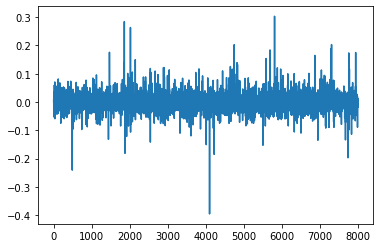

In [50]:
plt.plot(list(range(0,8000)),y_test_daily['Ret_PlusTwo'].values)

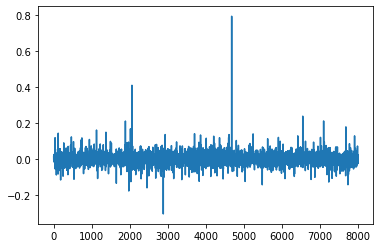

In [49]:
plt.plot(list(range(0,8000)),y_test_daily['Ret_PlusOne'].values)

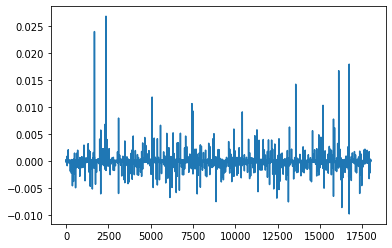

In [53]:
plt.plot(list(range(0,18000)),df_rf['Predicted'].values[:18000])

In [0]:
df_rf=pd.read_csv('randomForest.csv')

In [8]:
dict_rf = dict(zip(df_rf.Id, df_rf.Predicted))

min(dict_rf.values())

-0.08943143396428051

In [9]:
max(dict_rf.values())

0.07299291501881425

In [0]:
dict_rf['84_1']=-0.9

In [17]:
0 if dict_rf['84_1']==0 else  10e-6 if dict_rf['84_1']> 0 else -10e-6

-1e-05

In [54]:
dict_rf['1_1']

-8.699173362735828e-06

In [55]:
major_list=[]
for i in range(1,120000+1):
  for j in range(1,62+1):
    k=str(i)+'_'+str(j)
    major_list.append({'Id': k,
                       'Predicted': 0 if dict_rf[k]==0 else  10e-7 if dict_rf[k]> 0 else -10e-7
                      })

output = pd.DataFrame(data=major_list)
output.to_csv(path_or_buf="solution.csv",index=False)
!kaggle competitions submit -c the-winton-stock-market-challenge -f solution.csv -m " RF with squashing results"

100% 110M/110M [00:03<00:00, 38.0MB/s]
Successfully submitted to The Winton Stock Market Challenge